# Basic Statistics in Python

## Statistical Analysis

In [1]:
from scipy import stats
from scipy.stats import norm
import math
import yfinance as yf
yf.pdr_override()

In [2]:
import zipfile
import os
import alphalens as al
import quandl
import quantstats as qs
import matplotlib.pyplot as plt
import datetime as datetime
import numpy as np
import pandas as pd
import talib
import seaborn as sns
from time import time
from sklearn import preprocessing
import pytz
import itertools
import warnings
from time import sleep

warnings.filterwarnings("ignore")

In [3]:
import risk_model
import factorize
import account
import utils_s
import feature_weights

In [4]:
import matplotlib.dates as mdates 
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [5]:
secret_key = pd.read_csv('secret_key.txt',header=None)
quandl.ApiConfig.api_key = secret_key[0][0]

In [6]:
tod = datetime.datetime.today().date()
print ('current date: {}'.format(tod))

current date: 2020-07-24


In [7]:
# SF1
some_years = str(tod.year - 4)
month = str(tod.month)
day = str(tod.day)
start_f = '{}-{}-{}'.format(some_years,month,day)
print ('SF1 data starting date: {}'.format(start_f))

SF1 data starting date: 2016-7-24


In [8]:
# SEP & daily
two_years = str(tod.year - 3)
month = str(tod.month)
day = str(tod.day)
start_sep = '{}-{}-{}'.format(two_years,month,day)
print ('SEP,Daily and Sentiment data starting date: {}'.format(start_sep))

SEP,Daily and Sentiment data starting date: 2017-7-24


In [9]:
# Slicing data for 1y
years_to_slice = 1
year = str(tod.year - years_to_slice)
month = str(tod.month)
day = str(tod.day)
ayear = '{}-{}-{}'.format(year,month,day)

start = ayear
end = str(tod)
print ('Final slicing date for {} year: {}'.format(years_to_slice,ayear))

Final slicing date for 1 year: 2019-7-24


In [10]:
# input
market = '^GSPC'
# Read data 
dfm = yf.download(market,start_sep,end)

# View Columns
#df.head()

[*********************100%***********************]  1 of 1 completed


In [11]:
dfm = dfm.rename(columns={'Open': 'open', 
                          'High': 'high', 
                          'Low':'low', 
                          'Close':'close',
                          'Volume':'volume'}).drop('Adj Close', axis=1)
dfm.index.name = 'date'

In [12]:
with zipfile.ZipFile('data/ohlcv.zip', 'r') as zip_ref:
    zip_ref.extractall()

for item in os.listdir(os.getcwd()):  # loop through items in dir
    if item.endswith('.csv') and item.split('_')[0] == 'SHARADAR' and item.split('_')[1] == 'SEP':
        
        ohlcv = pd.read_csv(item)
        ohlcv['date'] = pd.to_datetime(ohlcv['date'])
        ohlcv = ohlcv.set_index(['date', 'ticker']).sort_index(level=[0,1], ascending=[True, False])
        ohlcv.drop(['lastupdated','dividends','closeunadj'],axis=1,inplace=True)

        os.remove(item)

cleaning data
columns are clean


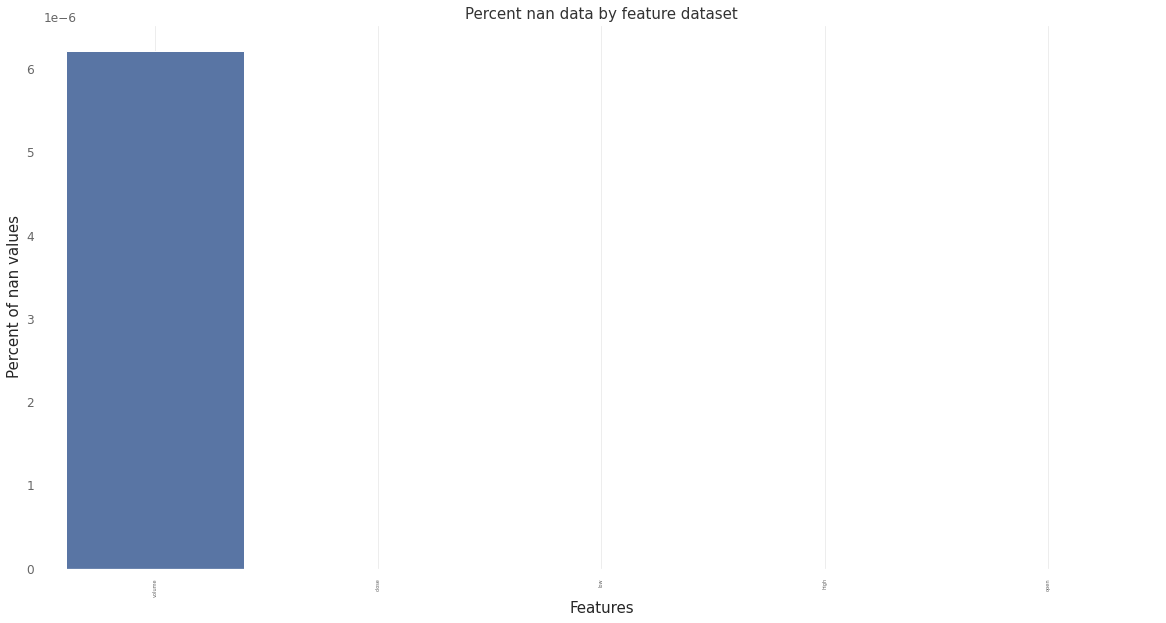

The percentage of dropped columns is 0%.
Dropped 0 columns out of 5


In [13]:
ohlcv = utils_s.cleaning_dataframe(ohlcv,0.2)

In [14]:
ticker = 'AAPL'

In [15]:
dfa = ohlcv.xs(ticker,level = 1)

In [16]:
new_df = pd.DataFrame({ticker : dfa['close'], market : dfm['close']}, index=dfa.index)

# compute returns
new_df[['stock_returns','market_returns']] = new_df[[ticker,market]] / new_df[[ticker,market]].shift(1) -1
new_df = new_df.dropna()
covmat = np.cov(new_df["stock_returns"],new_df["market_returns"])

# calculate measures now
beta = covmat[0,1]/covmat[1,1]
alpha= np.mean(new_df["stock_returns"])-beta*np.mean(new_df["market_returns"])

In [17]:
covmat

array([[0.00041098, 0.00023309],
       [0.00023309, 0.00020183]])

In [18]:
print('Beta:', beta)
print('Alpha:', alpha)

Beta: 1.1548547768891624
Alpha: 0.0008586056397347898


In [23]:
market_exposure = beta*(1+new_df["market_returns"]).cumprod()

In [19]:
y = (1+new_df["stock_returns"]).cumprod()
y.index = pd.to_datetime(y.index,format="%Y-%m-%d")

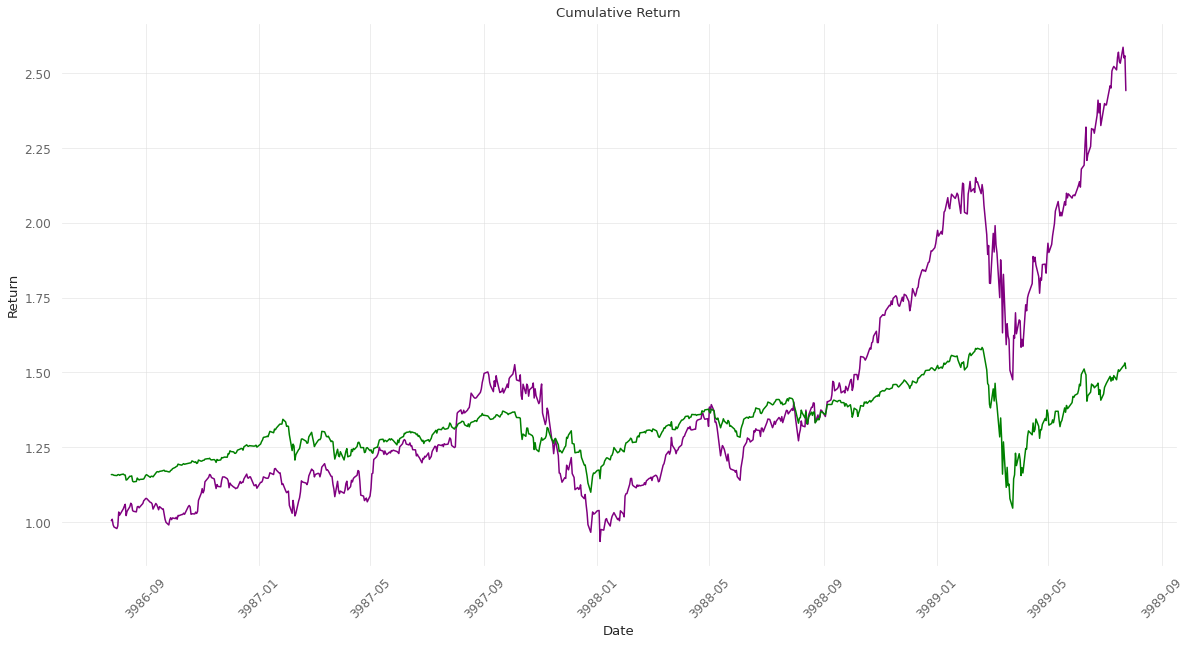

In [24]:
# Create figure and plot space
fig, ax = plt.subplots(figsize=(20, 10))
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# Add x-axis and y-axis
ax.plot(y,
        color='purple')
ax.plot(market_exposure,
        color='green')

# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="Return",
       title="Cumulative Return")

plt.setp(ax.get_xticklabels(), rotation=45)

plt.show()

In [ ]:
close = dfa['close']

## Mean is the average

In [7]:
mean = np.mean(close)
mean

166.18815917729088

## Median is the value of middlemost value

In [8]:
median = np.median(close)
median

165.22975150000002

## Mode is the most frequent value

In [9]:
mode = stats.mode(close)
print("The modal value is {} with a count of {}".format(mode.mode[0], mode.count[0]))

The modal value is 115.41264299999999 with a count of 2


## Range is a measure of how spread apart the values are

In [10]:
range_of_stock = np.ptp(close)
range_of_stock

117.807312

## Variance is a measure of how variable the data is

In [11]:
variance = np.var(close)
variance

726.388795436073

## Standard deviation is the square root of the variance and is measure how the data is spread out

In [12]:
standard_deviation = np.std(close)
standard_deviation

26.951600980944953

## Standard error is the mean (SE of the mean) estimates the variability between sample means that you would obtain if you took multiple samples from the same population

In [13]:
standard_error = stats.sem(close)
standard_error

1.2041087306392817

## Z-Scores measure how many standard deviations an element is from the mean

In [14]:
z = np.abs(stats.zscore(close))
print(z)

[ 2.02133922  2.02597913  2.00492469  1.95853364  1.91999404  1.91571192
  1.89287324  1.91071589  1.9182098   1.88395176  1.88430926  1.89180261
  1.88395176  1.8810972   1.88502235  1.8168635   1.81472229  1.81436562
  1.82578524  1.83577704  1.57170668  1.57955727  1.55993038  1.51675168
  1.4725024   1.45430337  1.42025564  1.4310072   1.38907493  1.3270713
  1.30950975  1.31524432  1.30198326  1.26686015  1.25216558  1.27295251
  1.26829364  1.25861693  1.25646666  1.15611622  1.18586143  1.15647346
  1.17224313  1.16579179  1.18442849  1.19589768  1.17941065  1.17726098
  1.18478688  1.13210218  1.12385896  1.14894585  1.09626227  1.1543232
  1.0976958   1.11561629  1.12565139  1.11704979  1.01239656  1.00092741
  1.00773769  1.01741497  1.01598147  0.97763351  1.00451172  1.01741497
  1.0288836   1.03497596  1.09016875  1.08407635  1.11095627  1.08300235
  1.10558008  1.1242179   1.06113856  1.06723212  1.01813118  0.9862334
  1.01669764  1.01275554  1.01777335  0.91276174  0.87

##  Contingency Table shows correlations between two variables

In [15]:
data_crosstab = pd.crosstab(df['High'], 
                            df['Low'],  
                               margins = False) 
print(data_crosstab) 

Low         114.760002  115.750000  115.809998  116.470001  117.940002  \
High                                                                     
116.330002           1           0           0           0           0   
116.510002           0           1           0           0           0   
116.860001           0           0           1           0           0   
118.160004           0           0           0           1           0   
119.300003           0           0           0           0           0   
119.379997           0           0           0           0           0   
119.430000           0           0           0           0           1   
119.620003           0           0           0           0           0   
119.930000           0           0           0           0           0   
120.089996           0           0           0           0           0   
120.099998           0           0           0           0           0   
120.239998           0           0    

## Scatter plot shows two variables that plot along two axes and it shows correlation or not

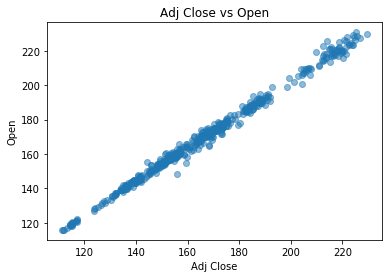

In [16]:
plt.scatter(df['Adj Close'], df['Open'], alpha=0.5)
plt.title('Adj Close vs Open')
plt.xlabel('Adj Close')
plt.ylabel('Open')
plt.show()

## Regression is a measure of the relation between the mean value of one variable (e.g. output) and corresponding values of other variables

In [33]:
from sklearn.linear_model import LinearRegression

X = np.array(dfa['open']).reshape(-1,1)[:150]
y = np.array(dfa['close'])[:150]
LR = LinearRegression().fit(X, y)
LR.score(X, y)

0.9533853355291655

In [34]:
LR.coef_

array([0.99033898])

In [35]:
LR.intercept_

1.6468086367775072

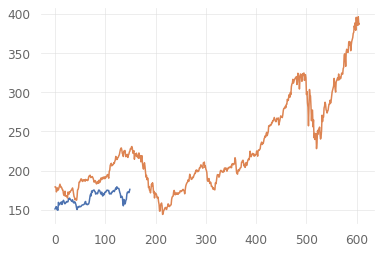

In [37]:
plt.plot(LR.predict(X))
plt.plot(np.array(dfa['open']).reshape(-1,1)[150:])

## Elementary Probability Theory the outcome that could happen

### Monte Carlo method is an experimentals of computational algorithms that rely on repeated random samples. 

In [21]:
df['Returns'] = df['Adj Close'].pct_change()
df['Returns'] = df['Returns'].dropna()

In [22]:
values = []
S = df['Returns'][-1] #Starting stock price 
T = 252 #Number of trading days
mu = df['Returns'].mean() #Mean
sigma = df['Returns'].std()*math.sqrt(252) #Volatility

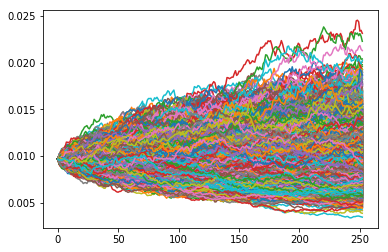

In [23]:
for i in range(10000):
    # Create list of daily returns using random normal distribution
    daily_returns=np.random.normal(mu/T,sigma/math.sqrt(T),T)+1
    
    # Set starting price and create price series generated by above random daily returns
    price_list = [S]
    
    for x in daily_returns:
        price_list.append(price_list[-1]*x)

    # Plot the data
    plt.plot(price_list)
plt.show()

## Random variables and probability distributions

https://www.investopedia.com/articles/06/probabilitydistribution.asp

### Cumulative Distribution 

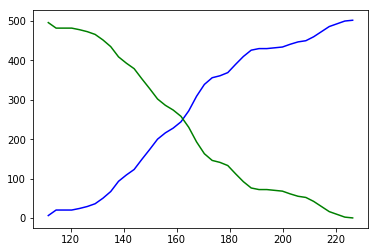

In [24]:
data = df['Adj Close']
values, base = np.histogram(data, bins=40)
#evaluate the cumulative
cumulative = np.cumsum(values)
# plot the cumulative function
plt.plot(base[:-1], cumulative, c='blue')
#plot the survival function
plt.plot(base[:-1], len(data)-cumulative, c='green')

plt.show()

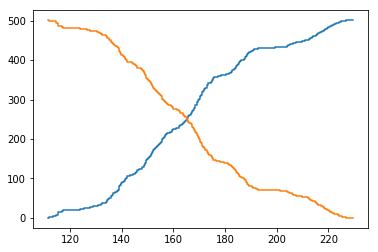

In [25]:
sorted_data = np.sort(data)  # Or data.sort(), if data can be modified

# Cumulative counts:
plt.step(sorted_data, np.arange(sorted_data.size))  # From 0 to the number of data points-1
plt.step(sorted_data[::-1], np.arange(sorted_data.size))  # From the number of data points-1 to 0

plt.show()

### Probability Density Function

Probability Density Function (PDF) is continuous random variable and have value that is given sample in the sample space can be interpreted as providing a relative likelihood that the value of the random variable would equal that sample. (Wikipedia)

Text(0.5,1,'Probability Density Function')

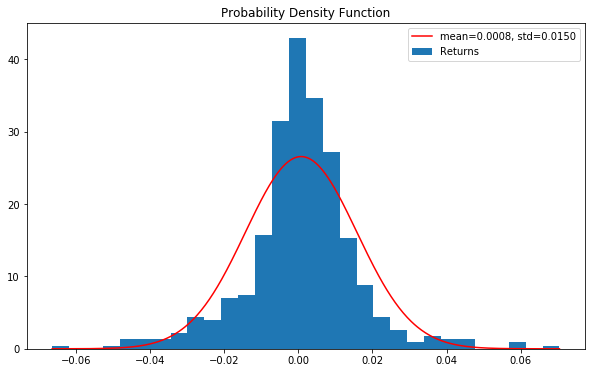

In [26]:
values = df['Returns'][1:]
x = np.linspace(values.min(), values.max(), len(values))
loc, scale = stats.norm.fit(values)
param_density = stats.norm.pdf(x, loc=loc, scale=scale)
label = 'mean=%.4f, std=%.4f' % (loc, scale)

fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(values, bins=30, normed=True)
ax.plot(x, param_density, 'r-', label=label)
ax.legend(loc='best')
ax.set_title("Probability Density Function")

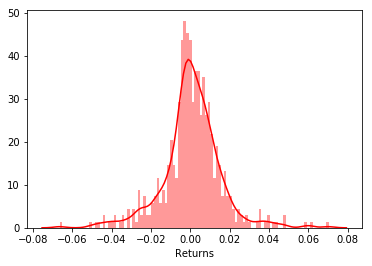

In [27]:
sns.distplot(df['Returns'].dropna(),bins=100,color='red')

## Cumulative Probability Distribution

Text(0.5,1,'Cumulative Probability Distribution')

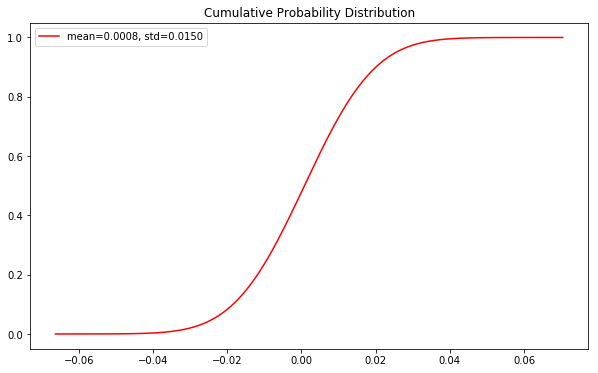

In [28]:
values = df['Returns'][1:]
x = np.linspace(values.min(), values.max(), len(values))
loc, scale = stats.norm.fit(values)
param_density = stats.norm.cdf(x, loc=loc, scale=scale)
label = 'mean=%.4f, std=%.4f' % (loc, scale)

fig, ax = plt.subplots(figsize=(10, 6))
#ax.hist(values, bins=30, normed=True)
ax.plot(x, param_density, 'r-', label=label)
ax.legend(loc='best')
ax.set_title("Cumulative Probability Distribution")

## Binomial Distribution

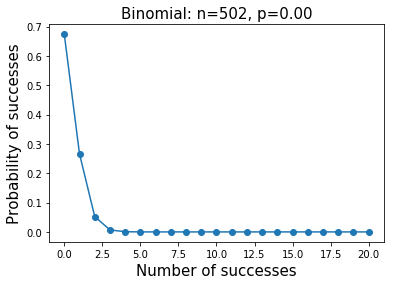

In [29]:
from scipy.stats import binom

n = len(df['Returns'])
p = df['Returns'].mean()
k = np.arange(0,21)
binomial = binom.pmf(k,n,p)

plt.plot(k, binomial, 'o-')
plt.title("Binomial: n=%i, p=%.2f" % (n,p), fontsize=15)
plt.xlabel("Number of successes", fontsize=15)
plt.ylabel("Probability of successes", fontsize=15)
plt.show()

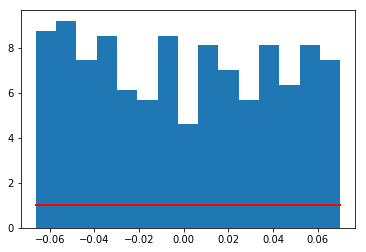

In [30]:
s = np.random.uniform(values.min(), values.max(), len(values))

import matplotlib.pyplot as plt
count, bins, ignored = plt.hist(s, 15, density=True)
plt.plot(bins, np.ones_like(bins), linewidth=2, color='r')
plt.show()

Mean: 0.391000
SD: 0.623665


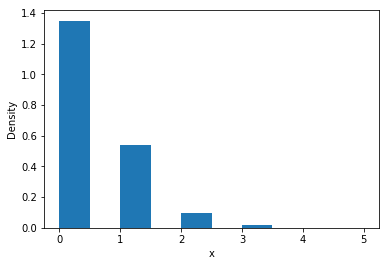

In [31]:
binom_sim = binom.rvs(n = n, p = p, size=10000)
print("Mean: %f" % np.mean(binom_sim))
print("SD: %f" % np.std(binom_sim, ddof=1))
plt.hist(binom_sim, bins = 10, normed = True)
plt.xlabel("x")
plt.ylabel("Density")
plt.show()

## Poisson Distribution

In [32]:
rate = 3 # Error Rate
n = np.arange(0,10) # Number of Trials
y = stats.poisson.pmf(n, rate)
y

array([ 0.04978707,  0.14936121,  0.22404181,  0.22404181,  0.16803136,
        0.10081881,  0.05040941,  0.02160403,  0.00810151,  0.0027005 ])

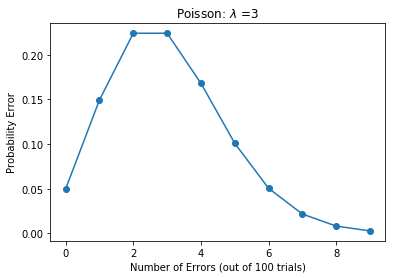

In [33]:
plt.plot(n, y, 'o-')
plt.title('Poisson: $\lambda$ =%i' % rate)
plt.ylabel('Probability Error')
plt.xlabel('Number of Errors (out of 100 trials)')
plt.show()

Mean: 3.080000
Standard Deviation: 1.574288


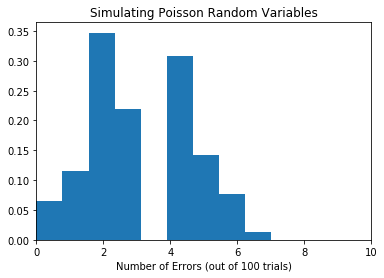

In [34]:
data = stats.poisson.rvs(mu=3, loc=0, size=100)
print("Mean: %f" % np.mean(data))
print("Standard Deviation: %f" % np.std(data, ddof=1))

plt.hist(data, bins = 9, normed = True)
plt.xlim(0,10)
plt.xlabel('Number of Errors (out of 100 trials)')
plt.title('Simulating Poisson Random Variables')
plt.show()

## Beta Distribution

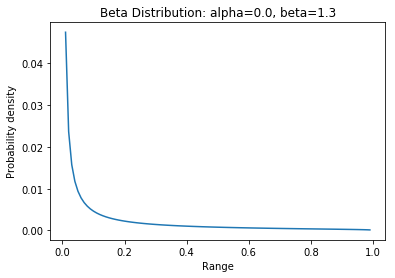

In [35]:
alpha = alpha
beta = beta
x = np.arange(0, 1, 0.01)
y = stats.beta.pdf(x, alpha, beta)
plt.plot(x, y)
plt.title('Beta Distribution: alpha=%.1f, beta=%.1f' % (alpha,beta))
plt.xlabel('Range')
plt.ylabel('Probability density')
plt.show()

## Exponential Distribution

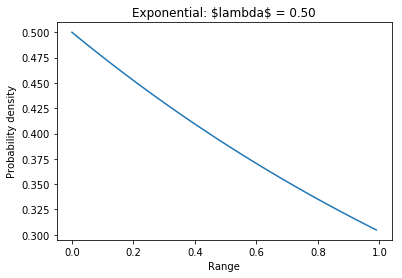

In [36]:
lambd = 0.5 # lambda
x = np.arange(0, 1, 0.01)
y = lambd * np.exp(-lambd * x)
plt.plot(x, y)
plt.title('Exponential: $lambda\$ = %.2f' % lambd)
plt.xlabel("Range")
plt.ylabel("Probability density")
plt.show()

## Lognormal Distribution 

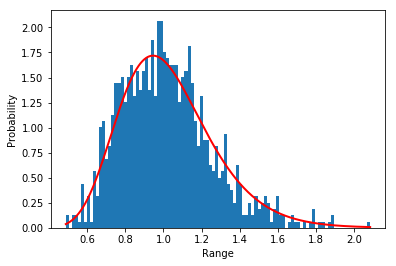

In [37]:
from scipy.stats import lognorm

s = np.random.lognormal(mu, sigma, 1000)

count, bins, ignored = plt.hist(s, 100, normed=True, align='mid')
x = np.linspace(min(bins), max(bins), 10000)
pdf = (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2)) / (x * sigma * np.sqrt(2 * np.pi)))

plt.plot(x, pdf, linewidth=2, color='r')
plt.xlabel('Range')
plt.ylabel('Probability')
plt.axis('tight')
plt.show()